In [1]:
import os
import subprocess
import numpy as np
import pandas as pd
import seaborn as sns
from itertools import product
from tqdm.auto import tqdm
from datasets import available_datasets
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

sns.set_style('whitegrid')
sns.set_context("talk")
pd.set_option('display.width', 2000)

## Helper Functions

In [28]:
def read_tensorboard_logs(path, tasks, datasets, label_rates, methods, epsilons, hops, aggs, loops, metrics=None):
    non_priv_methods = [method for method in ['raw', 'rnd'] if method in methods]
    priv_methods = [method for method in methods if method not in non_priv_methods]
    configs = list(product(tasks, datasets, label_rates, non_priv_methods, [0.0], hops, aggs, loops))
    configs += list(product(tasks, datasets, label_rates, priv_methods, epsilons, hops, aggs, loops))
    
    data = []
    for task, dataset, label_rate, method, eps, k, agg, loop in tqdm(configs):
        experiment_dir = os.path.join(
            path,
            f'task:{task}',
            f'dataset:{dataset}({label_rate})',
            f'method:{method}',
            f'eps:{eps}',
            f'step:{k}',
            f'agg:{agg}',
            f'loops:{loop}'
        )
        versions = os.listdir(experiment_dir)
        
        for version in versions:
            event_path = os.path.join(experiment_dir, version)
            output = subprocess.getoutput(f'find "{event_path}" -type f -name "*tfevents*"')
            event_file = output.splitlines()[-1]

            event_acc = EventAccumulator(event_file)
            event_acc.Reload()

            if metrics is None: 
                metrics = event_acc.scalars.Keys()
                
            for metric in metrics:
                if metric in event_acc.scalars.Keys():
                    scalars = event_acc.Scalars(metric)
                    for item in scalars:
                        data.append([
                            task, dataset, label_rate, method, eps, k, agg, loop, 
                            version, metric, item.step, item.value
                        ])

    df = pd.DataFrame(data, columns=[
        'task', 'dataset', 'labelrate', 'method', 'eps', 'hop', 'agg', 'loop', 'version', 'metric', 'step', 'value'
    ])
    return df


def read_csv_logs(path, tasks, datasets, methods, epsilons, aggs, metrics=None):
    non_priv_methods = [method for method in ['raw', 'rnd'] if method in methods]
    priv_methods = [method for method in methods if method not in non_priv_methods]
    configs = list(product(tasks, datasets, non_priv_methods, [0.0], aggs))
    configs += list(product(tasks, datasets, priv_methods, epsilons, aggs))
    
    data = pd.DataFrame()
    for task, dataset, method, eps, agg in tqdm(configs):
        experiment_dir = os.path.join(
            path,
            f'task:{task}',
            f'dataset:{dataset}',
            f'method:{method}',
            f'eps:{eps}',
            f'agg:{agg}',
        )
        versions = os.listdir(experiment_dir)
        
        for version in versions:
            event_file = os.path.join(experiment_dir, version, 'metrics.csv')
            df = pd.read_csv(event_file)

            if metrics is not None: 
                df = df.loc[:, metrics]
                
            df['task'] = task
            df['dataset'] = dataset
            df['method'] = method
            df['eps'] = eps
            df['agg'] = agg
            data = data.append(df, ignore_index=True)
            
    return data


def explode(df, col, val):
    df[col] = [val for _ in range(len(df))]
    df = df.explode(col, ignore_index=True)
    return df


def export_figure(path, df, x, y, hue, row, col, group, error=None):
    if not os.path.exists(path):
        os.makedirs(path)
    
    if error is None:
        df = df.groupby([group, row, col, hue, x])[y].agg(['mean', np.std]).reset_index()
        output = [x, 'mean', 'std']
    else:
        output = [x, y, error]
        
    df['filename'] = df[[group, row, col, hue]].apply(lambda row: '-'.join(row.astype(str)) + f'-{x}.txt', axis=1)
    df.groupby('filename').apply(
        lambda row: row[output].to_csv(
            os.path.join(path, row['filename'].unique().item()), 
            index=None, 
            sep=' '
        )
    )
    

def latex_output(df_results, top_method, colored_method=None, color=None, size=None):
    if size is not None:
        df_results = df_results.applymap(lambda x: f'{{{size} {x}}}')
        
    if color is not None:
        df_results.loc[pd.IndexSlice[:, 'DPGNN'], :] = df_results.loc[pd.IndexSlice[:, 'DPGNN'], :].applymap(
            lambda x: f'\textcolor{{{color}}}{{{x}}}'
        )
        
    # print latex code
    cols = df_results.shape[1] + 2
    latex = df_results.to_latex(escape=False)
    for line in latex.splitlines():
        if line.find(top_method + ' ') == -1:
            print(line)
        else:
            print('\\midrule')
            print(line)

## Analysis of the utility-privacy trade-off

In [4]:
datasets = available_datasets()
epsilons = [0.1, 0.5, 1.0, 2.0, 4.0]
metrics = ['test_acc']

data_dpgnn = read_tensorboard_logs(
    path='results/',
    tasks=['node'],
    datasets=datasets, 
    methods=['mbm'], 
    epsilons=epsilons,
    hops=[1,2,4,8,16,32],
    aggs=['gcn'],
    loops=[False],
    metrics=metrics
)

data_gcn = read_tensorboard_logs(
    path='results/',
    tasks=['node'],
    datasets=datasets, 
    methods=['raw'], 
    epsilons=[0.0],
    hops=[1],
    aggs=['gcn'],
    loops=[True],
    metrics=metrics
)

data_rnd = read_tensorboard_logs(
    path='results/',
    tasks=['node'],
    datasets=datasets, 
    methods=['rnd'], 
    epsilons=[0.0],
    hops=[1],
    aggs=['gcn'],
    loops=[True],
    metrics=metrics
)

data_gcn = explode(data_gcn, col='eps', val=epsilons)
data_rnd = explode(data_rnd, col='eps', val=epsilons)

In [16]:
names = {
    'raw': '1-GCN+Raw',
    'mbm': '2-DPGNN',
    'rnd': '3-GCN+Rnd',
    'cora': '1-Cora',
    'citeseer': '2-Citeseer',
    'pubmed': '3-Pubmed',
    'facebook': '4-Facebook',
    'github': '5-Github',
    'lastfm': '6-LastFM'
}
df_mean = data_dpgnn.groupby(['dataset', 'eps', 'hop'])['value'].mean().reset_index()
idx = df_mean.groupby(['dataset', 'eps'])['value'].transform(max) == df_mean['value']
df_max = df_mean[idx]
df_final = data_dpgnn.merge(df_max.drop(columns='value'), on=['dataset', 'eps', 'hop'], how='inner')
data = df_final.append(data_gcn, ignore_index=True).append(data_rnd, ignore_index=True)
data = data.groupby(['dataset', 'method', 'eps']).agg({'value': ['mean', lambda x: np.std(x)]}).reset_index()
data = data.replace(names)
data.columns = ['Dataset', 'Method', '$\epsilon$', 'mean', 'std']
data['result'] = data[['mean', 'std']].apply(lambda row: '%.1f $\pm$ %.1f' % (row['mean']*100, row['std']*100), axis=1)
data = data.drop(columns=['mean', 'std']).set_index(['Dataset', 'Method', '$\epsilon$'])
data = data.unstack()
data = data.rename(index=lambda name: name[2:] if name[1] == '-' else name)
data
# latex_output(data, top_method='GCN+Raw', size='\scriptsize', color='blue', colored_method='DPGNN')

result                                                                
$\epsilon$                   0.1             0.5             1.0             2.0             4.0
Dataset  Method                                                                                 
Cora     GCN+Raw  84.3 $\pm$ 1.0  84.3 $\pm$ 1.0  84.3 $\pm$ 1.0  84.3 $\pm$ 1.0  84.3 $\pm$ 1.0
         DPGNN    83.9 $\pm$ 0.6  83.8 $\pm$ 0.3  84.2 $\pm$ 0.3  84.0 $\pm$ 0.5  84.0 $\pm$ 0.5
         GCN+Rnd  76.4 $\pm$ 1.2  76.4 $\pm$ 1.2  76.4 $\pm$ 1.2  76.4 $\pm$ 1.2  76.4 $\pm$ 1.2
Citeseer GCN+Raw  77.9 $\pm$ 0.4  77.9 $\pm$ 0.4  77.9 $\pm$ 0.4  77.9 $\pm$ 0.4  77.9 $\pm$ 0.4
         DPGNN    70.5 $\pm$ 0.6  70.0 $\pm$ 0.7  70.5 $\pm$ 0.5  70.0 $\pm$ 0.8  69.7 $\pm$ 0.6
         GCN+Rnd  58.3 $\pm$ 9.3  58.3 $\pm$ 9.3  58.3 $\pm$ 9.3  58.3 $\pm$ 9.3  58.3 $\pm$ 9.3
Pubmed   GCN+Raw  87.8 $\pm$ 0.4  87.8 $\pm$ 0.4  87.8 $\pm$ 0.4  87.8 $\pm$ 0.4  87.8 $\pm$ 0.4
         DPGNN    83.8 $\pm$ 0.7  83.7 $\pm$ 0.2  84.1 $\pm$ 0.4  83.8 $\pm$ 0.5  83.9 $\pm$ 0.4
         GCN+Rnd  60.2 $\pm$ 2.2  60.2 $\pm$ 2.2  60.2 $\pm$ 2.2  60.2 $\pm$ 2.2  60.2 $\pm$ 2.2
Facebook GCN+Raw  94.0 $\pm$ 0.1  94.0 $\pm$ 0.1  94.0 $\pm$ 0.1  94.0 $\pm$ 0.1  94.0 $\pm$ 0.1
         DPGNN    93.6 $\pm$ 0.2  93.6 $\pm$ 0.2  93.6 $\pm$ 0.2  93.6 $\pm$ 0.2  93.7 $\pm$ 0.2
         GCN+Rnd  37.0 $\pm$ 2.8  37.0 $\pm$ 2.8  37.0 $\pm$ 2.8  37.0 $\pm$ 2.8  37.0 $\pm$ 2.8
Github   GCN+Raw  86.8 $\pm$ 0.2  86.8 $\pm$ 0.2  86.8 $\pm$ 0.2  86.8 $\pm$ 0.2  86.8 $\pm$ 0.2
         DPGNN    86.2 $\pm$ 0.2  86.2 $\pm$ 0.2  86.2 $\pm$ 0.2  86.2 $\pm$ 0.1  86.1 $\pm$ 0.1
         GCN+Rnd  74.2 $\pm$ 0.0  74.2 $\pm$ 0.0  74.2 $\pm$ 0.0  74.2 $\pm$ 0.0  74.2 $\pm$ 0.0
LastFM   GCN+Raw  88.0 $\pm$ 0.3  88.0 $\pm$ 0.3  88.0 $\pm$ 0.3  88.0 $\pm$ 0.3  88.0 $\pm$ 0.3
         DPGNN    86.5 $\pm$ 0.3  86.6 $\pm$ 0.2  86.7 $\pm$ 0.2  86.7 $\pm$ 0.2  86.6 $\pm$ 0.2
         GCN+Rnd  20.6 $\pm$ 1.6  20.6 $\pm$ 1.6  20.6 $\pm$ 1.6  20.6 $\pm$ 1.6  20.6 $\pm$ 1.6

## Studying the effect of KProp

In [4]:
epsilons = [0.1, 1.0, 4.0]
hops = [1, 2, 4, 8, 16, 32]
metrics = ['test_acc']

data_dpgnn = read_tensorboard_logs(
    path='results/',
    tasks=['node'],
    datasets=available_datasets(), 
    methods=['mbm'], 
    epsilons=epsilons,
    hops=hops,
    aggs=['gcn'],
    loops=[False],
    metrics=metrics
)

data_gcn = read_tensorboard_logs(
    path='results/',
    tasks=['node'],
    datasets=available_datasets(), 
    methods=['raw'], 
    epsilons=[0.0],
    hops=hops,
    aggs=['gcn'],
    loops=[False],
    metrics=metrics
)

data = data_dpgnn.append(data_gcn, ignore_index=True)

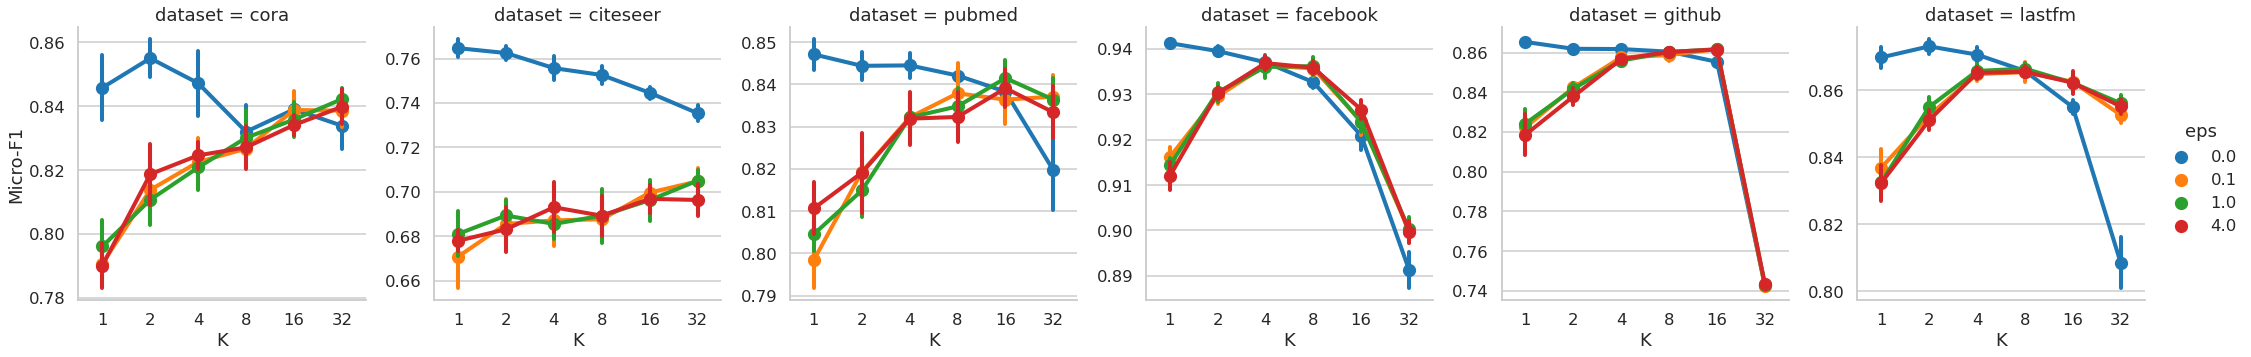

In [8]:
ax = sns.catplot(
    kind='point', data=data, x='hop', y='value', hue='eps', col='dataset', ci='sd',
    sharex=False, sharey=False,
)

ax.set_ylabels('Micro-F1')
ax.set_xlabels('K')

export_figure(path='figures', df=data, x='hop', y='value', hue='eps', row='agg', col='dataset', group='task')

In [9]:
epsilons = [1.0]
hops = [1, 2, 4, 8, 16, 32]
metrics = ['test_acc']

data = read_tensorboard_logs(
    path='results/',
    tasks=['node'],
    datasets=available_datasets(), 
    methods=['mbm'], 
    epsilons=epsilons,
    hops=hops,
    aggs=['gcn'],
    loops=[False, True],
    metrics=metrics
)

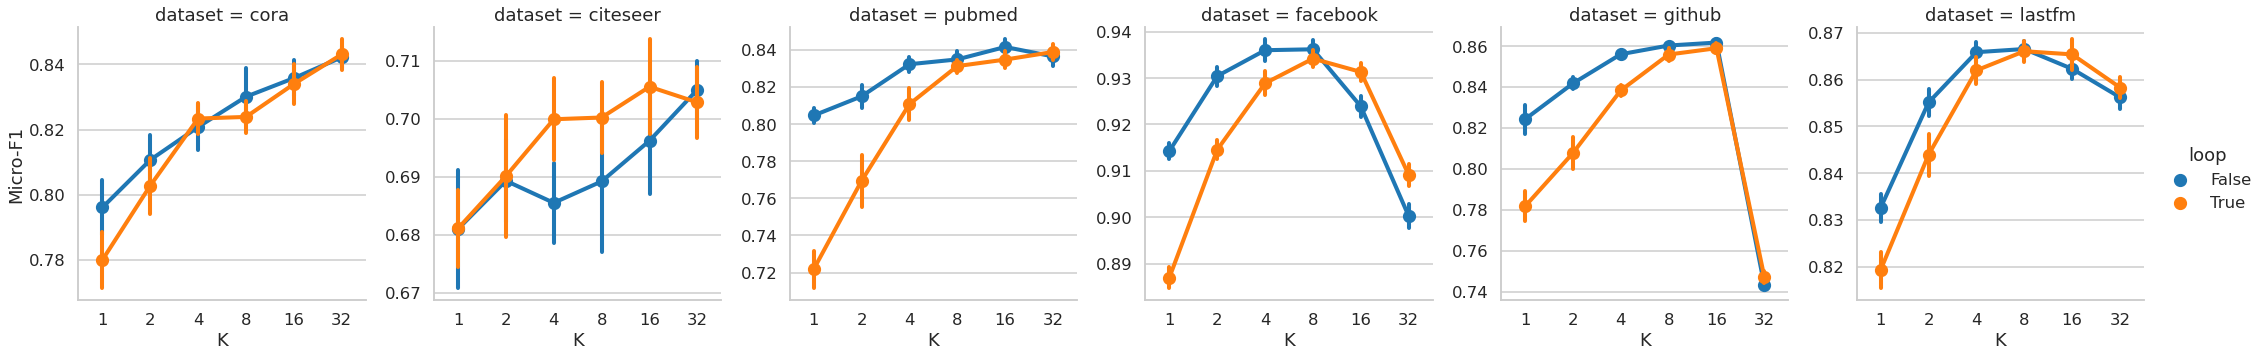

In [10]:
ax = sns.catplot(
    kind='point', data=data, x='hop', y='value', hue='loop', col='dataset', ci='sd',
    sharex=False, sharey=False,
)

ax.set_ylabels('Micro-F1')
ax.set_xlabels('K')

export_figure(path='figures', df=data, x='hop', y='value', hue='loop', row='agg', col='dataset', group='task')

## Studying the effect of multi-bit mechanism

In [19]:
df_error = read_csv_logs(
    path='results/', 
    tasks=['eps'], 
    datasets=available_datasets(), 
    methods=['obm', 'agm', 'mbm'], 
    epsilons=[0.5, 1.0, 2.0, 4.0], 
    aggs=['gcn'], 
)

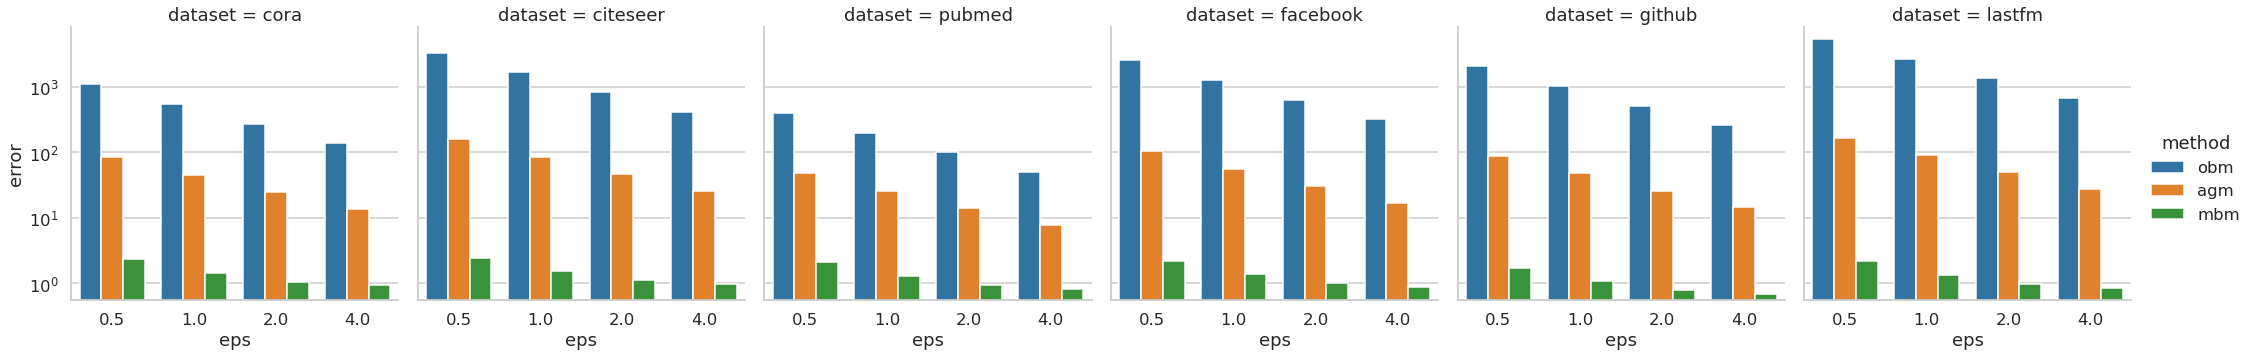

In [20]:
ax = sns.catplot(
    kind='bar', data=df_error, x='eps', y='error', hue='method', col='dataset', ci=None, sharey=True
)
ax.set(yscale='log')

export_figure(
    path='figures', df=df_error, x='eps', y='error', hue='method', 
    col='dataset', row='agg', error='std', group='task'
)

In [21]:
df_error = read_csv_logs(
    path='results/', 
    tasks=['eps'], 
    datasets=available_datasets(), 
    methods=['mbm'], 
    epsilons=[0.5, 1.0, 2.0, 4.0], 
    aggs=['mean', 'gcn'], 
)

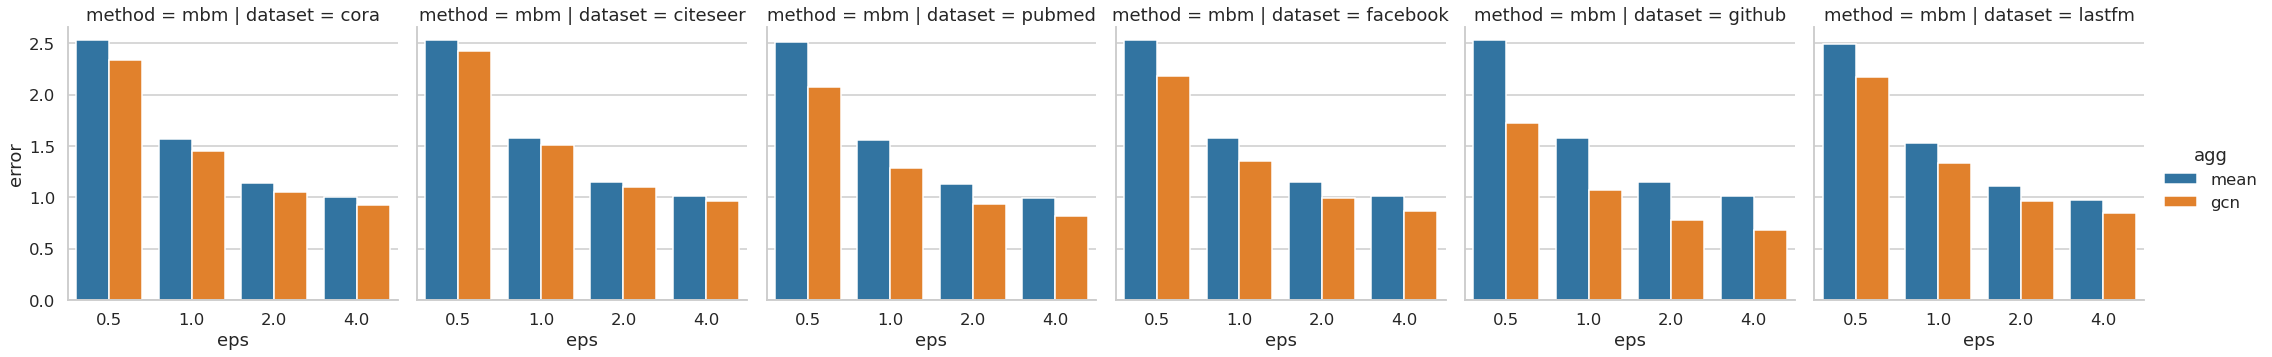

In [22]:
ax = sns.catplot(
    kind='bar', data=df_error, x='eps', y='error', hue='agg', col='dataset', row='method', ci=None, sharey=True
)

export_figure(
    path='figures', df=df_error, x='eps', y='error', hue='agg', 
    col='dataset', row='method', error='std', group='task'
)

## Analysis of the model convergence

In [24]:
data = read_tensorboard_logs(
    path='results/',
    tasks=['node'],
    datasets=available_datasets(), 
    methods=['mbm'], 
    epsilons=[0.1, 1.0, 4.0],
    hops=[1],
    aggs=['gcn'],
    loops=[False],
    metrics=['train_loss']
)

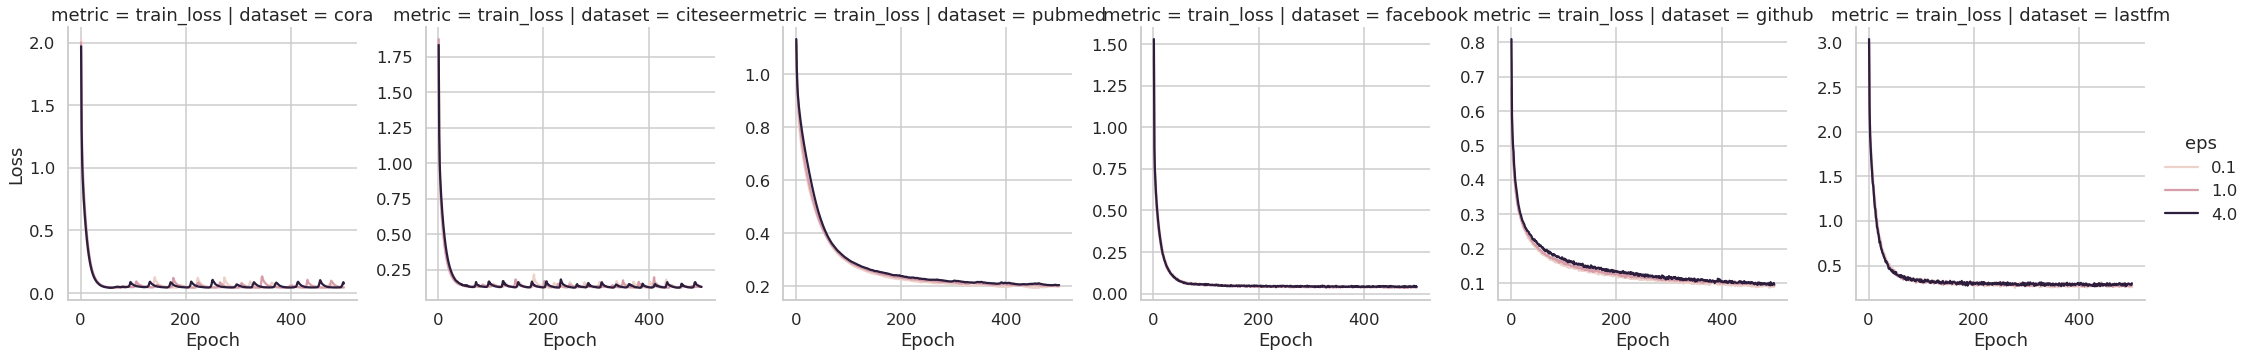

In [25]:
ax = sns.relplot(
    data=data, kind='line', x='step', y='value', hue='eps', row='metric', col='dataset',
    facet_kws=dict(sharey=False, sharex=False), ci=None
)
ax.set_ylabels('Loss')
ax.set_xlabels('Epoch')

export_figure(path='figures', df=data, x='step', y='value', hue='eps', row='metric', col='dataset', group='task')

In [26]:
data = read_tensorboard_logs(
    path='results/',
    tasks=['node'],
    datasets=available_datasets(), 
    methods=['mbm'], 
    epsilons=[1.0],
    hops=[1, 4, 8],
    aggs=['gcn'],
    loops=[False],
    metrics=['train_loss']
)

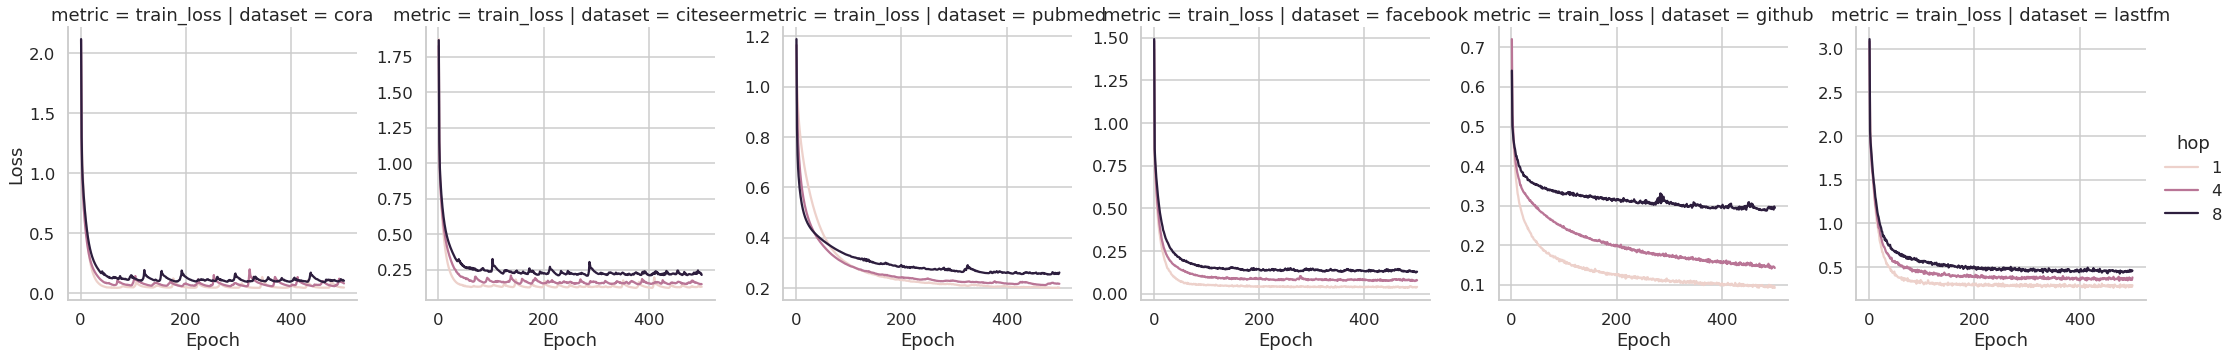

In [27]:
ax = sns.relplot(
    data=data, kind='line', x='step', y='value', hue='hop', row='metric', col='dataset',
    facet_kws=dict(sharey=False, sharex=False), ci=None
)
ax.set_ylabels('Loss')
ax.set_xlabels('Epoch')

export_figure(path='figures', df=data, x='step', y='value', hue='hop', row='metric', col='dataset', group='task')

## Effect of label rate

In [38]:
data = read_tensorboard_logs(
    path='temp/',
    tasks=['node'],
    datasets=available_datasets(), 
    label_rates=[0.2, 0.4, 0.6, 0.8, 1.0],
    methods=['mbm'], 
    epsilons=[1.0],
    hops=[2, 4, 8],
    aggs=['gcn'],
    loops=[False],
    metrics=['test_acc']
)

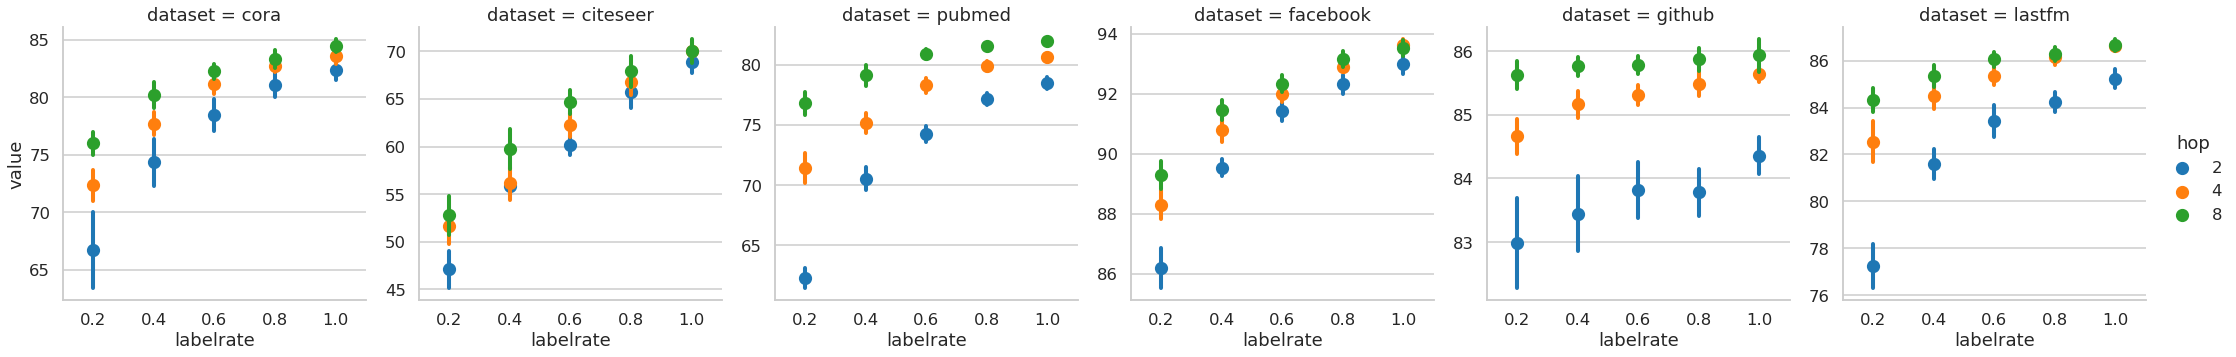

In [44]:
ax = sns.catplot(
    kind='point', data=data, x='labelrate', y='value', hue='hop', col='dataset', ci='sd',
    sharex=False, sharey=False, join=False
)

# ax.set(ylim=40)
export_figure(path='figures', df=data, x='labelrate', y='value', hue='hop', row='agg', col='dataset', group='task')

In [45]:
data = read_tensorboard_logs(
    path='temp/',
    tasks=['node'],
    datasets=available_datasets(), 
    label_rates=[0.2, 0.4, 0.6, 0.8, 1.0],
    methods=['mbm'], 
    epsilons=[0.5, 1.0, 2.0],
    hops=[8],
    aggs=['gcn'],
    loops=[False],
    metrics=['test_acc']
)

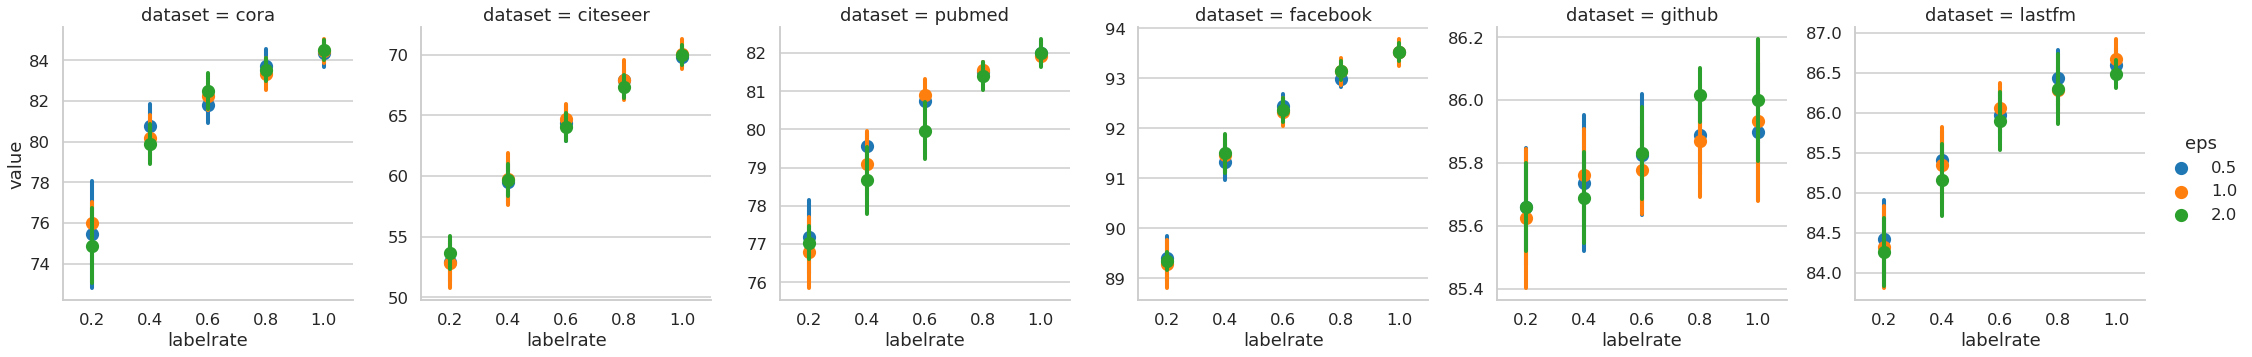

In [46]:
ax = sns.catplot(
    kind='point', data=data, x='labelrate', y='value', hue='eps', col='dataset', ci='sd',
    sharex=False, sharey=False, join=False
)

export_figure(path='figures', df=data, x='labelrate', y='value', hue='eps', row='agg', col='dataset', group='task')